In [1]:
import re
import os

import pyproj
from xcube.core.store import new_data_store
import xarray as xr
from xcube_resampling import resample_in_time

In [2]:
team_store = new_data_store(
    "s3", 
    root=os.environ["S3_USER_STORAGE_BUCKET"], 
    storage_options=dict(
        anon=False, 
        key=os.environ["S3_USER_STORAGE_KEY"],
        secret=os.environ["S3_USER_STORAGE_SECRET"],
    )
)

---

In [3]:
cmems_store =  new_data_store("cmems")

In [4]:
time_range = ("2023-06-01", "2023-06-30")
bbox = [4.3, 58.0, 6.5, 59.6]

Get all the data ids in cmems datastore

In [5]:
all_data_ids = list(cmems_store.get_data_ids())
len(all_data_ids)

1256

In [6]:
data_ids_sel = [d for d in all_data_ids if re.search("oc.*nws.*", d)]
data_ids_sel

['cmems_obs-oc_nws_bgc-optics_nrt_l3-hr-mosaic_P1D-m',
 'cmems_obs_oc_nws_bgc_geophy_nrt_l3-hr_P1D-m',
 'cmems_obs_oc_nws_bgc_optics_nrt_l3-hr_P1D-m',
 'cmems_obs_oc_nws_bgc_transp_nrt_l3-hr_P1D-m',
 'cmems_obs_oc_nws_bgc_tur-spm-chl_nrt_l3-hr-mosaic_P1D-m',
 'cmems_obs-oc_nws_bgc-optics_nrt_l4-hr-mosaic_P1D-m',
 'cmems_obs-oc_nws_bgc-optics_nrt_l4-hr-mosaic_P1M-m',
 'cmems_obs-oc_nws_bgc-tur-spm-chl_nrt_l4-hr-mosaic_P1M-m',
 'cmems_obs_oc_nws_bgc_geophy_nrt_l4-hr_P1D-m',
 'cmems_obs_oc_nws_bgc_geophy_nrt_l4-hr_P1M-m',
 'cmems_obs_oc_nws_bgc_optics_nrt_l4-hr_P1D-m',
 'cmems_obs_oc_nws_bgc_optics_nrt_l4-hr_P1M-m',
 'cmems_obs_oc_nws_bgc_transp_nrt_l4-hr_P1D-m',
 'cmems_obs_oc_nws_bgc_transp_nrt_l4-hr_P1M-m',
 'cmems_obs_oc_nws_bgc_tur-spm-chl_nrt_l4-hr-mosaic_P1D-m']

---

In [7]:
%%time
ds = cmems_store.open_data(
    'cmems_obs_oc_nws_bgc_tur-spm-chl_nrt_l3-hr-mosaic_P1D-m',
    time_range=time_range,
    bbox=bbox,
)
ds

INFO - 2025-12-10T11:46:41Z - Selected dataset version: "202107"
INFO - 2025-12-10T11:46:41Z - Selected dataset part: "default"


CPU times: user 410 ms, sys: 68 ms, total: 478 ms
Wall time: 1.6 s


<xarray.Dataset> Size: 784MB
Dimensions:    (time: 30, latitude: 1728, longitude: 1260)
Coordinates:
  * time       (time) datetime64[ns] 240B 2023-06-01 2023-06-02 ... 2023-06-30
  * latitude   (latitude) float64 14kB 58.0 58.0 58.0 58.0 ... 59.6 59.6 59.6
  * longitude  (longitude) float64 10kB 4.3 4.302 4.304 ... 6.496 6.498 6.5
Data variables:
    CHL        (time, latitude, longitude) float32 261MB dask.array<chunksize=(25, 1728, 1024), meta=np.ndarray>
    SPM        (time, latitude, longitude) float32 261MB dask.array<chunksize=(25, 1728, 1024), meta=np.ndarray>
    TUR        (time, latitude, longitude) float32 261MB dask.array<chunksize=(25, 1728, 1024), meta=np.ndarray>
Attributes:
    references:   https://marine.copernicus.eu/
    source:       Sentinel-2 MSI L1C
    title:        CMEMS HR-OC North West Shelf Region transparency (spm, tur)...
    institution:  Brockmann Consult GmbH, RBINS, VITO for CMEMS, Mercator Ocean
    contact:      https://marine.copernicus.eu/
    history:      Calvalus 2.21 mosaic generation; Acolite 20210203; C2RCC 8....
    Conventions:  CF-1.7

In [8]:
del ds.CHL.attrs["valid_min"]
del ds.SPM.attrs["valid_min"]
del ds.TUR.attrs["valid_min"]
ds = ds.chunk(dict(time=1, latitude=-1, longitude=-1))
ds = resample_in_time(ds, frequency="1D", agg_methods="mean")
ds

<xarray.Dataset> Size: 784MB
Dimensions:    (latitude: 1728, longitude: 1260, time: 30)
Coordinates:
  * latitude   (latitude) float64 14kB 58.0 58.0 58.0 58.0 ... 59.6 59.6 59.6
  * longitude  (longitude) float64 10kB 4.3 4.302 4.304 ... 6.496 6.498 6.5
  * time       (time) datetime64[ns] 240B 2023-06-01 2023-06-02 ... 2023-06-30
Data variables:
    CHL_mean   (time, latitude, longitude) float32 261MB dask.array<chunksize=(1, 1728, 1260), meta=np.ndarray>
    SPM_mean   (time, latitude, longitude) float32 261MB dask.array<chunksize=(1, 1728, 1260), meta=np.ndarray>
    TUR_mean   (time, latitude, longitude) float32 261MB dask.array<chunksize=(1, 1728, 1260), meta=np.ndarray>
Attributes:
    references:           https://marine.copernicus.eu/
    source:               Sentinel-2 MSI L1C
    title:                CMEMS HR-OC North West Shelf Region transparency (s...
    institution:          Brockmann Consult GmbH, RBINS, VITO for CMEMS, Merc...
    contact:              https://marine.copernicus.eu/
    history:              Calvalus 2.21 mosaic generation; Acolite 20210203; ...
    Conventions:          CF-1.7
    time_coverage_start:  <xarray.DataArray 'time' ()> Size: 8B\narray('2023-...
    time_coverage_end:    <xarray.DataArray 'time' ()> Size: 8B\narray('2023-...

In [10]:
ds.CHL_mean.attrs

{'long_name': 'Chlorophyll-a concentration derived from MSI L2R using HR-OC L2W processor',
 'standard_name': 'mass_concentration_of_chlorophyll_a_in_sea_water',
 'units': 'mg m-3'}

In [9]:
%%time
team_store.write_data(ds,'oc_nws_l3_cmems.zarr', replace=True)

CPU times: user 9.39 s, sys: 1.38 s, total: 10.8 s
Wall time: 13.2 s


'oc_nws_l3_cmems.zarr'

---

In [5]:
%%time
ds = cmems_store.open_data(
    'cmems_obs_oc_nws_bgc_tur-spm-chl_nrt_l4-hr-mosaic_P1D-m',
    time_range=time_range,
    bbox=bbox,
)
del ds.CHL.attrs["valid_min"]
del ds.SPM.attrs["valid_min"]
del ds.TUR.attrs["valid_min"]
ds = ds.chunk(dict(time=1, latitude=-1, longitude=-1))
ds = resample_in_time(ds, frequency="1D", agg_methods="mean")
ds

INFO - 2025-12-04T11:09:07Z - Selected dataset version: "202107"
INFO - 2025-12-04T11:09:07Z - Selected dataset part: "default"


CPU times: user 471 ms, sys: 164 ms, total: 636 ms
Wall time: 5.39 s


<xarray.Dataset> Size: 784MB
Dimensions:    (latitude: 1728, longitude: 1260, time: 30)
Coordinates:
  * latitude   (latitude) float64 14kB 58.0 58.0 58.0 58.0 ... 59.6 59.6 59.6
  * longitude  (longitude) float64 10kB 4.3 4.302 4.304 ... 6.496 6.498 6.5
  * time       (time) datetime64[ns] 240B 2023-06-01 2023-06-02 ... 2023-06-30
Data variables:
    CHL_mean   (time, latitude, longitude) float32 261MB dask.array<chunksize=(1, 1728, 1260), meta=np.ndarray>
    SPM_mean   (time, latitude, longitude) float32 261MB dask.array<chunksize=(1, 1728, 1260), meta=np.ndarray>
    TUR_mean   (time, latitude, longitude) float32 261MB dask.array<chunksize=(1, 1728, 1260), meta=np.ndarray>
Attributes:
    references:           https://marine.copernicus.eu/
    history:              Calvalus 2.21 mosaic generation; Acolite 20210203; ...
    Conventions:          CF-1.7
    source:               Sentinel-2 MSI L1C
    title:                CMEMS HR-OC North West Shelf Region transparency (s...
    institution:          Brockmann Consult GmbH, RBINS, VITO for CMEMS, Merc...
    contact:              https://marine.copernicus.eu/
    time_coverage_start:  <xarray.DataArray 'time' ()> Size: 8B\narray('2023-...
    time_coverage_end:    <xarray.DataArray 'time' ()> Size: 8B\narray('2023-...

In [6]:
%%time
team_store.write_data(ds,'oc_nws_cmems.zarr', replace=True)

CPU times: user 12.5 s, sys: 1.83 s, total: 14.3 s
Wall time: 14.4 s


'oc_nws_cmems.zarr'

---

In [9]:
[d for d in all_data_ids if re.search(".*oc.*glo.*bgc.*plankton.*1D", d)]

['cmems_obs-oc_glo_bgc-plankton_my_l3-multi-4km_P1D',
 'cmems_obs-oc_glo_bgc-plankton_my_l3-olci-300m_P1D',
 'cmems_obs-oc_glo_bgc-plankton_my_l3-olci-4km_P1D',
 'c3s_obs-oc_glo_bgc-plankton_my_l3-multi-4km_P1D',
 'cmems_obs-oc_glo_bgc-plankton_nrt_l3-multi-4km_P1D',
 'cmems_obs-oc_glo_bgc-plankton_nrt_l3-olci-300m_P1D',
 'cmems_obs-oc_glo_bgc-plankton_nrt_l3-olci-4km_P1D',
 'cmems_obs-oc_glo_bgc-plankton_my_l4-gapfree-multi-4km_P1D',
 'cmems_obs-oc_glo_bgc-plankton_my_l4-multi-climatology-4km_P1D',
 'cmems_obs-oc_glo_bgc-plankton_nrt_l4-gapfree-multi-4km_P1D']

In [7]:
ds = cmems_store.open_data(
    "cmems_obs-oc_glo_bgc-plankton_my_l4-gapfree-multi-4km_P1D",
    time_range=time_range,
    bbox=bbox,
)
ds = ds.chunk(dict(time=1, latitude=-1, longitude=-1))
ds = resample_in_time(ds, frequency="1D", agg_methods="mean")
ds

INFO - 2025-12-04T11:09:37Z - Selected dataset version: "202311"
INFO - 2025-12-04T11:09:37Z - Selected dataset part: "default"


<xarray.Dataset> Size: 1MB
Dimensions:               (latitude: 38, longitude: 53, time: 30)
Coordinates:
  * latitude              (latitude) float32 152B 58.02 58.06 ... 59.52 59.56
  * longitude             (longitude) float32 212B 4.313 4.354 ... 6.438 6.479
  * time                  (time) datetime64[ns] 240B 2023-06-01 ... 2023-06-30
Data variables:
    CHL_mean              (time, latitude, longitude) float32 242kB dask.array<chunksize=(1, 38, 53), meta=np.ndarray>
    CHL_uncertainty_mean  (time, latitude, longitude) float64 483kB dask.array<chunksize=(1, 38, 53), meta=np.ndarray>
    flags_mean            (time, latitude, longitude) float64 483kB dask.array<chunksize=(1, 38, 53), meta=np.ndarray>
Attributes:
    references:           http://www.globcolour.info GlobColour has been orig...
    history:              Created using software developed at ACRI-ST
    Conventions:          CF-1.8, ACDD-1.3
    source:               surface observation
    title:                cmems_obs-oc_glo_bgc-plankton_my_l4-gapfree-multi-4...
    comment:              average
    institution:          ACRI
    contact:              servicedesk.cmems@acri-st.fr
    time_coverage_start:  <xarray.DataArray 'time' ()> Size: 8B\narray('2023-...
    time_coverage_end:    <xarray.DataArray 'time' ()> Size: 8B\narray('2023-...

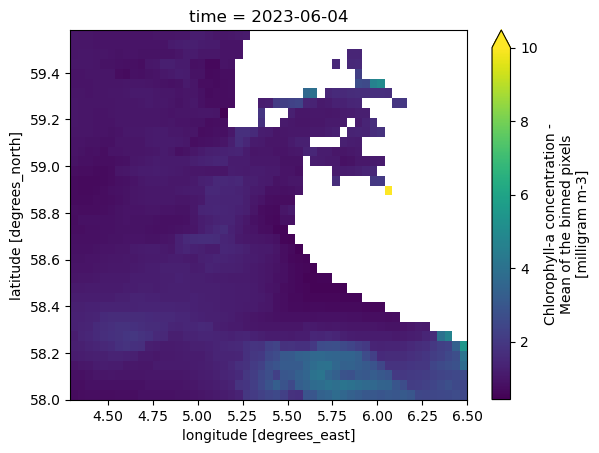

In [9]:
ds.CHL_mean.isel(time=3).plot(vmax=10)

In [10]:
%%time
team_store.write_data(ds,'oc_glo_cmems_4km.zarr', replace=True)

CPU times: user 6.21 s, sys: 992 ms, total: 7.21 s
Wall time: 11.4 s


'oc_glo_cmems_4km.zarr'

---

In [14]:
ds = cmems_store.open_data(
    'cmems_obs-oc_glo_bgc-plankton_my_l3-olci-300m_P1D',
    time_range=time_range,
    bbox=bbox,
)
ds = ds.chunk(dict(time=1, latitude=-1, longitude=-1))
ds = resample_in_time(ds, frequency="1D", agg_methods="mean")
ds

INFO - 2025-12-04T11:12:55Z - Selected dataset version: "202211"
INFO - 2025-12-04T11:12:55Z - Selected dataset part: "default"


<xarray.Dataset> Size: 68MB
Dimensions:               (latitude: 288, longitude: 396, time: 30)
Coordinates:
  * latitude              (latitude) float32 1kB 58.0 58.01 58.01 ... 59.59 59.6
  * longitude             (longitude) float32 2kB 4.303 4.308 ... 6.492 6.497
  * time                  (time) datetime64[ns] 240B 2023-06-01 ... 2023-06-30
Data variables:
    CHL_mean              (time, latitude, longitude) float32 14MB dask.array<chunksize=(1, 288, 396), meta=np.ndarray>
    CHL_uncertainty_mean  (time, latitude, longitude) float64 27MB dask.array<chunksize=(1, 288, 396), meta=np.ndarray>
    flags_mean            (time, latitude, longitude) float64 27MB dask.array<chunksize=(1, 288, 396), meta=np.ndarray>
Attributes:
    references:           http://www.globcolour.info GlobColour has been orig...
    history:              Created using software developed at ACRI-ST
    Conventions:          CF-1.8, ACDD-1.3
    source:               surface observation
    title:                cmems_obs-oc_glo_bgc-plankton_my_l3-olci-300m_P1D
    comment:              average
    institution:          ACRI
    contact:              servicedesk.cmems@acri-st.fr
    time_coverage_start:  <xarray.DataArray 'time' ()> Size: 8B\narray('2023-...
    time_coverage_end:    <xarray.DataArray 'time' ()> Size: 8B\narray('2023-...

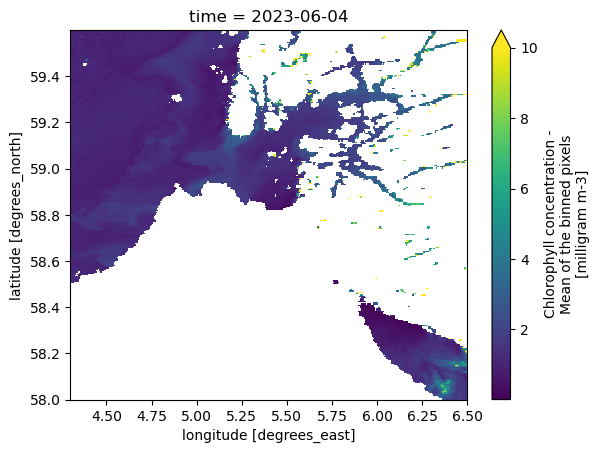

In [15]:
ds.CHL_mean.isel(time=3).plot(vmax=10)

In [16]:
%%time
team_store.write_data(ds,'oc_glo_cmems_300m.zarr', replace=True)

CPU times: user 3.29 s, sys: 340 ms, total: 3.63 s
Wall time: 6.46 s


'oc_glo_cmems_300m.zarr'

In [3]:
ds = team_store.open_data("oc_glo_cmems_4km.zarr")
ds

<xarray.Dataset> Size: 1MB
Dimensions:               (time: 30, latitude: 38, longitude: 53)
Coordinates:
  * time                  (time) datetime64[ns] 240B 2023-06-01 ... 2023-06-30
  * latitude              (latitude) float32 152B 58.02 58.06 ... 59.52 59.56
  * longitude             (longitude) float32 212B 4.313 4.354 ... 6.438 6.479
Data variables:
    CHL_mean              (time, latitude, longitude) float32 242kB dask.array<chunksize=(1, 38, 53), meta=np.ndarray>
    CHL_uncertainty_mean  (time, latitude, longitude) float64 483kB dask.array<chunksize=(1, 38, 53), meta=np.ndarray>
    flags_mean            (time, latitude, longitude) float64 483kB dask.array<chunksize=(1, 38, 53), meta=np.ndarray>
Attributes:
    Conventions:          CF-1.8, ACDD-1.3
    comment:              average
    contact:              servicedesk.cmems@acri-st.fr
    history:              Created using software developed at ACRI-ST
    institution:          ACRI
    references:           http://www.globcolour.info GlobColour has been orig...
    source:               surface observation
    time_coverage_end:    <xarray.DataArray 'time' ()> Size: 8B\narray('2023-...
    time_coverage_start:  <xarray.DataArray 'time' ()> Size: 8B\narray('2023-...
    title:                cmems_obs-oc_glo_bgc-plankton_my_l4-gapfree-multi-4...

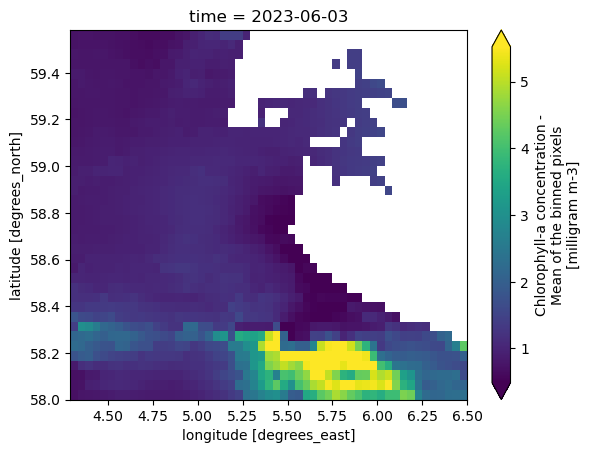

In [5]:
ds.CHL_mean.isel(time=2).plot(robust=True)